In [32]:
import os
data_folder = os.path.join(os.path.expanduser("~"),"Datamining","ch11", "Data", "cifar-10-batches-py")

In [33]:
batch1_filename = os.path.join(data_folder, "data_batch_1")

In [34]:
import pickle
# Bugfix thanks to: http://stackoverflow.com/questions/11305790/pickle-incompatability-of-numpy-arrays-between-python-2-and-3 
def unpickle(filename):
    with open(filename, 'rb') as fo: 
        return pickle.load(fo, encoding='latin1')

In [35]:
batch1 = unpickle(batch1_filename)

In [36]:
image_index = 100
image = batch1['data'][image_index]

In [37]:
image = image.reshape((32,32, 3), order='F')
import numpy as np
image = np.rot90(image, -1)

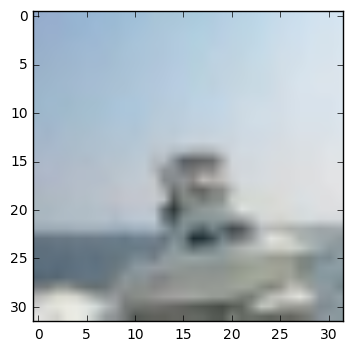

In [38]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(image)

In [39]:
import tensorflow as tf
# Define the parameters of the equation as constant values
a = tf.constant(5.0)
b = tf.constant(4.5)
c = tf.constant(3.0)
# Define the variable x, which lets its value be changed
x = tf.Variable(0., name='x') # Default of 0.0
# Define the output y, which is an operation on a, b, c and x
y = (a * x ** 2) + (b * x) + c

In [40]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [41]:
show_graph(tf.get_default_graph().as_graph_def())

In [42]:
model = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(model)
    result = session.run(y)
print(result)

3.0


In [43]:
model = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(model)
    session.run(x.assign(10))
    result = session.run(y)
print(result)


548.0


In [101]:
import os
import numpy as np 

data_folder = os.path.join(os.path.expanduser("~"),"Datamining","ch11", "Data", "cifar-10-batches-py")

batches = [] 
for i in range(1, 6):
    batch_filename = os.path.join(data_folder, "data_batch_{}".format(i))
    batches.append(unpickle(batch_filename)) 
    #break

In [102]:
X = np.vstack([batch['data'] for batch in batches])

In [103]:
X = np.array(X) / X.max()
X = X.astype(np.float32)

In [104]:
from keras.utils import np_utils
y = np.hstack(batch['labels'] for batch in batches).flatten()
nb_classes = len(np.unique(y))
y = np_utils.to_categorical(y, nb_classes)

E:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [106]:
X_train = X_train.reshape(-1, 3, 32, 32)
X_test = X_test.reshape(-1, 3, 32, 32)
n_samples, d, h, w = X_train.shape # Obtain dataset dimensions
# Convert to floats and ensure data is normalised.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [107]:
from keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D

In [108]:
from keras import backend as K
K.set_image_dim_ordering('th')

In [109]:
conv1 = Convolution2D(32, 3, 3, input_shape=(d, h, w), activation='relu')
pool1 = MaxPooling2D()
conv2 = Convolution2D(64, 2, 2, activation='relu')
pool2 = MaxPooling2D()
conv3 = Convolution2D(128, 2, 2, activation='relu')
pool3 = MaxPooling2D()
flatten = Flatten()
hidden4 = Dense(500, activation='relu')
hidden5 = Dense(500, activation='relu')
output = Dense(nb_classes, activation='softmax')
layers = [conv1, pool1,
conv2, pool2,
conv3, pool3,
flatten, hidden4, hidden5,
output]

E:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(3, 32, 32..., activation="relu")`
  if __name__ == '__main__':
E:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 2), activation="relu")`
  app.launch_new_instance()
E:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (2, 2), activation="relu")`


In [110]:
model = Sequential(layers=layers)


In [111]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
import tensorflow as tf

In [112]:
history = model.fit(X_train, y_train, nb_epoch=1, verbose=False,
                   validation_data=(X_test, y_test))

E:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


In [113]:
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_pred=y_pred.argmax(axis=1),
y_true=y_test.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.63      0.57      0.60       993
           1       0.58      0.81      0.67       972
           2       0.52      0.31      0.39       990
           3       0.39      0.27      0.32       994
           4       0.51      0.39      0.44      1010
           5       0.57      0.36      0.45      1014
           6       0.38      0.88      0.53       988
           7       0.64      0.65      0.64      1034
           8       0.87      0.37      0.52       970
           9       0.57      0.70      0.63      1035

   micro avg       0.53      0.53      0.53     10000
   macro avg       0.57      0.53      0.52     10000
weighted avg       0.56      0.53      0.52     10000



In [114]:
history = model.fit(X_train, y_train, nb_epoch=25, verbose=True,
validation_data=(X_test, y_test),batch_size=1000)

E:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 207s 5ms/step - loss: 0.0524 - acc: 0.6037 - val_loss: 0.0513 - val_acc: 0.6111
Epoch 2/25
40000/40000 [==============================] - 200s 5ms/step - loss: 0.0479 - acc: 0.6388 - val_loss: 0.0498 - val_acc: 0.6259
Epoch 3/25
40000/40000 [==============================] - 200s 5ms/step - loss: 0.0461 - acc: 0.6563 - val_loss: 0.0485 - val_acc: 0.6350
Epoch 4/25
40000/40000 [==============================] - 202s 5ms/step - loss: 0.0444 - acc: 0.6724 - val_loss: 0.0473 - val_acc: 0.6444
Epoch 5/25
40000/40000 [==============================] - 202s 5ms/step - loss: 0.0427 - acc: 0.6868 - val_loss: 0.0466 - val_acc: 0.6526
Epoch 6/25
40000/40000 [==============================] - 201s 5ms/step - loss: 0.0410 - acc: 0.7018 - val_loss: 0.0453 - val_acc: 0.6634
Epoch 7/25
40000/40000 [==============================] - 201s 5ms/step - loss: 0.0392 - acc: 0.7164 - val_loss: 0.0444 - 

In [115]:
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_pred=y_pred.argmax(axis=1),
y_true=y_test.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       993
           1       0.84      0.81      0.83       972
           2       0.60      0.65      0.62       990
           3       0.50      0.59      0.54       994
           4       0.69      0.66      0.68      1010
           5       0.63      0.53      0.58      1014
           6       0.77      0.77      0.77       988
           7       0.77      0.73      0.75      1034
           8       0.79      0.83      0.81       970
           9       0.80      0.79      0.79      1035

   micro avg       0.71      0.71      0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000

